In [6]:
!pip  install filelock --quiet
!pip install nni --quiet

In [7]:
import nni
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from nni.nas.evaluator.pytorch import DataLoader

import numpy as np
from nni.nas.evaluator.pytorch import Classification
from torch.utils.data import SubsetRandomSampler
from nni.nas.hub.pytorch import DARTS as DartsSpace
from nni.nas.space import model_context

import matplotlib.pyplot as plt
from IPython.display import clear_output
import graphviz
import io
from PIL import Image

from tqdm import tqdm

import json
import os
import random

/usr/local/lib/python3.10/dist-packages/nni/nas/nn/pytorch/layers.py:94: RuntimeWarning: <class 'torch.nn.parameter.Buffer'> is found to be not a nn.Module, which is unexpected. It means your PyTorch version might not be supported.
  warnings.warn(f'{obj} is found to be not a nn.Module, which is unexpected. '


In [35]:
CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
CIFAR_STD = [0.24703233, 0.24348505, 0.26158768]

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

train_data = nni.trace(CIFAR10)(root='./data', train=True, download=True, transform=transform)

num_samples = len(train_data)
indices = np.random.permutation(num_samples)
split = int(num_samples * 0.8)

search_train_loader = DataLoader(
    train_data, batch_size=4096, num_workers=6,
    sampler=SubsetRandomSampler(indices[:split]),
)

search_valid_loader = DataLoader(
    train_data, batch_size=4096, num_workers=6,
    sampler=SubsetRandomSampler(indices[split:]),
)

Files already downloaded and verified


In [36]:
def load_json_from_directory(directory_path):
    json_data = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        json_data.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {file_path}: {e}")
    return json_data
    
arch_dicts = load_json_from_directory('/kaggle/input/second-dataset/best_models/')

In [17]:
def plot_single_cell(arch_dict, cell_name):
    g = graphviz.Digraph(
        node_attr=dict(style='filled', shape='rect', align='center'),
        format='png'
    )
    g.body.extend(['rankdir=LR'])

    g.node('c_{k-2}', fillcolor='darkseagreen2')
    g.node('c_{k-1}', fillcolor='darkseagreen2')

    max_nodes = max([int(key.split('_')[1]) for key in arch_dict.keys() if key.startswith(f'{cell_name}/op_')])

    for i in range(2, max_nodes + 1):
        g.node(str(i), fillcolor='lightblue')

    for i in range(2, max_nodes + 1):
        for j in range(2):
            op = arch_dict[f'{cell_name}/op_{i}_{j}']
            from_ = arch_dict[f'{cell_name}/input_{i}_{j}']
            
            if from_ == [0]:
                u = 'c_{k-2}'
            elif from_ == [1]:
                u = 'c_{k-1}'
            else:
                u = str(from_)
            v = str(i)
            g.edge(u, v, label=op, fillcolor='gray')

    g.node('c_{k}', fillcolor='palegoldenrod')
    for i in range(2, max_nodes + 1):
        g.edge(str(i), 'c_{k}', fillcolor='gray')

    g.attr(label=f'{cell_name.capitalize()} cell')

    image = Image.open(io.BytesIO(g.pipe()))
    return image

def plot_cells(arch_dict, cell_names):
    images = [plot_single_cell(arch_dict, cell_name) for cell_name in cell_names]
    
    height_ratio = max(image.size[1] / image.size[0] for image in images)
    
    _, axs = plt.subplots(1, len(images), figsize=(20 * len(images), 10 * height_ratio))
    
    if len(images) == 1:
        axs = [axs]
    
    for ax, image in zip(axs, images):
        ax.imshow(image)
        ax.axis('off')

    plt.show()

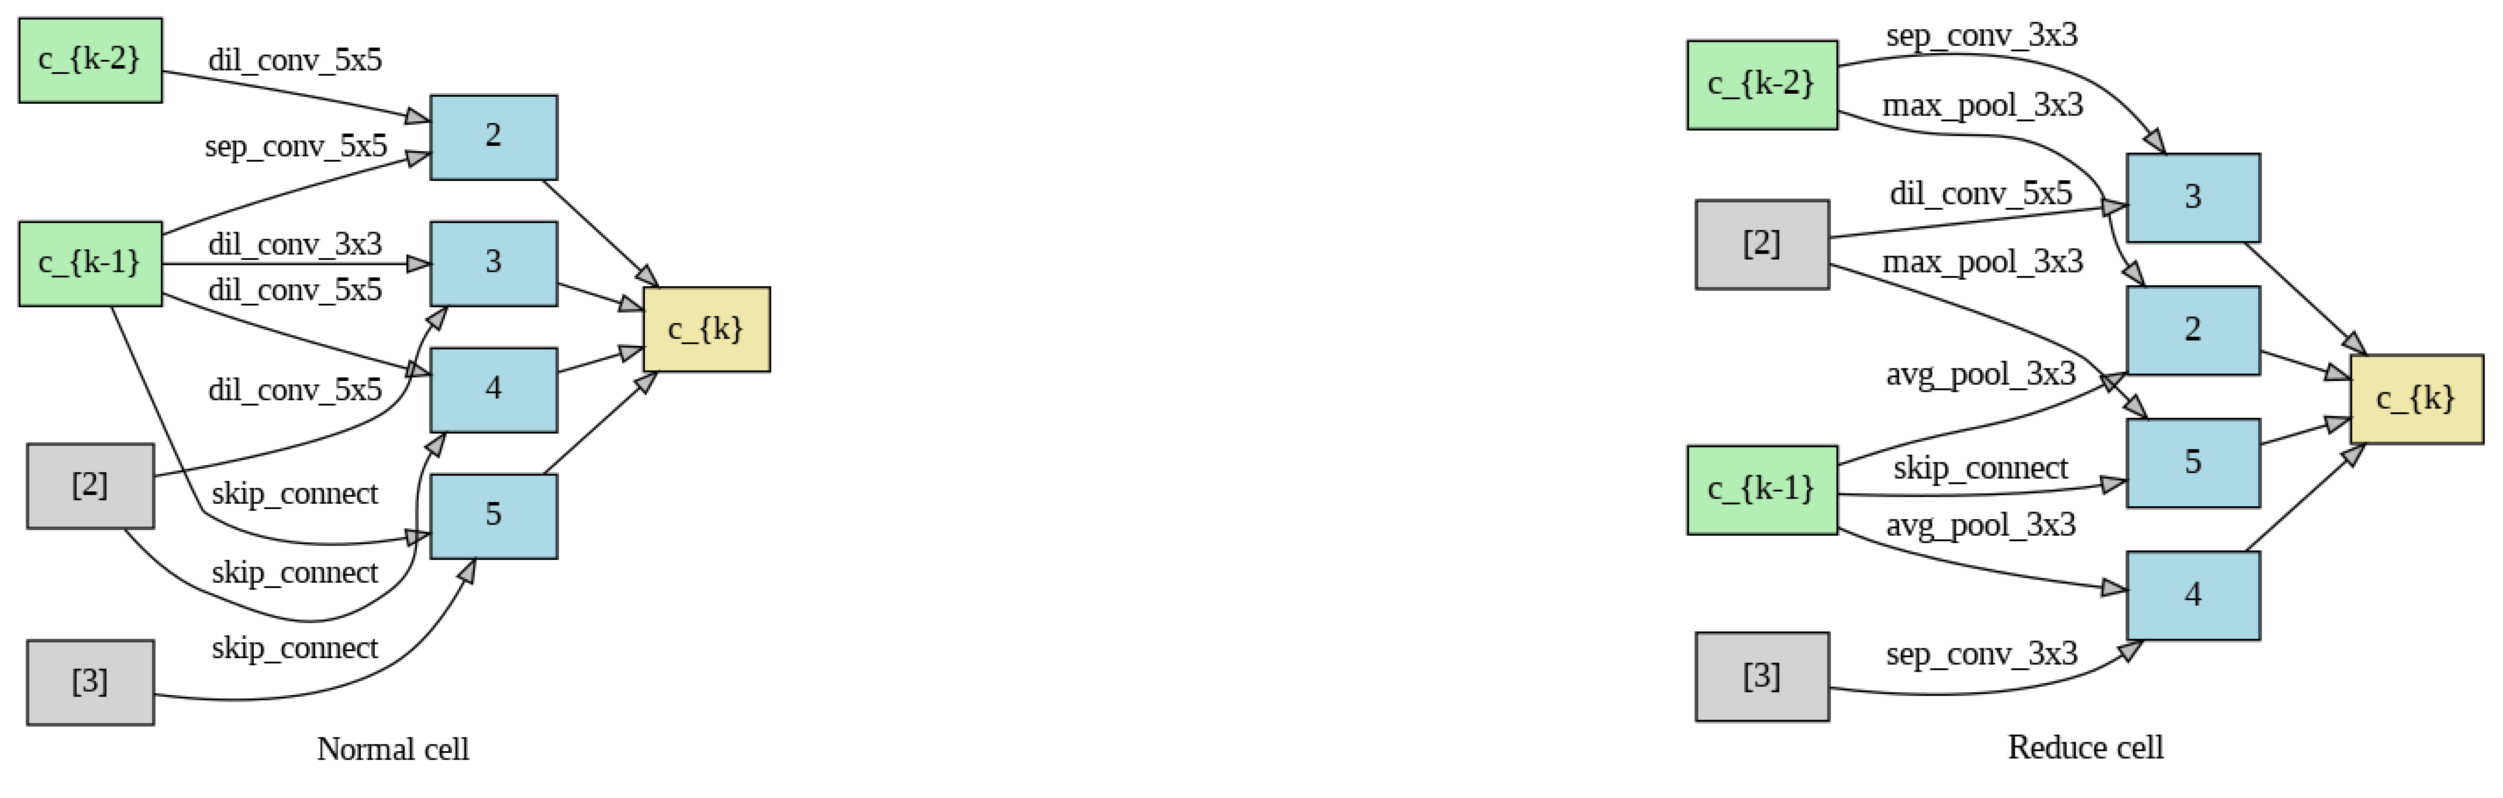

In [18]:
plot_cells(arch_dicts[0], ['normal', 'reduce'])

In [37]:
def train_model(architecture, train_loader, valid_loader, max_epochs=10, learning_rate=1e-3):
    with model_context(architecture):
        model = DartsSpace(width=16, num_cells=3, dataset='cifar')
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)  # Enable multi-GPU training
    
    model.to(device)
    
    evaluator = Classification(
        learning_rate=learning_rate,
        weight_decay=1e-3,
        train_dataloaders=train_loader,
        val_dataloaders=valid_loader,
        max_epochs=max_epochs,
        num_classes=10,
        export_onnx=False,          # Disable ONNX export for this experiment
        fast_dev_run=False,   # Should be false for fully training
    )
    
    evaluator.fit(model)
    
    return model


In [38]:
models = []
architectures = []
for architecture in tqdm(arch_dicts[:5]):
    model = train_model(architecture, search_train_loader, search_valid_loader, max_epochs=40)
    
    models.append(model)
    architectures.append(architecture)
    clear_output(wait=True)


100%|██████████| 5/5 [56:19<00:00, 675.82s/it]


In [39]:
def evaluate_ensemble(models, valid_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Переносим все модели на главное устройство (cuda:0)
    models = [model.to('cuda:0') for model in models]  # Явно указываем главное устройство
    
    # Включаем DataParallel только если есть несколько GPU
    if torch.cuda.device_count() > 1:
        models = [torch.nn.DataParallel(model, device_ids=[0]) for model in models]  # Все вычисления на cuda:0
    
    for model in models:
        model.eval()

    correct = 0
    total = 0
    model_accuracies = []

    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            images = images.to('cuda:0')  # Все данные на главное устройство
            labels = labels.to('cuda:0')
            
            ensemble_outputs = []
            model_predictions = []
            
            # Вычисляем предсказания для каждой модели и сохраняем их точности
            for model in models:
                outputs = model(images)
                ensemble_outputs.append(outputs)
                
                # Для каждой модели считаем точность
                _, predicted = torch.max(outputs.data, 1)
                correct_model = (predicted == labels).sum().item()
                accuracy_model = 100 * correct_model / labels.size(0)
                model_predictions.append(accuracy_model)

            # Среднее значение для ансамбля
            avg_outputs = torch.mean(torch.stack(ensemble_outputs), dim=0)
            _, predicted = torch.max(avg_outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Вычисляем точность ансамбля
    ensemble_accuracy = 100 * correct / total

    # Выводим точность ансамбля и каждой модели
    print(f'Ensemble Accuracy: {ensemble_accuracy:.2f}%')
    for i, accuracy in enumerate(model_predictions):
        print(f'Model {i + 1} Accuracy: {accuracy:.2f}%')

    return ensemble_accuracy, model_predictions


In [40]:
evaluate_ensemble(models, search_valid_loader)


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]

Ensemble Accuracy: 78.53%
Model 1 Accuracy: 72.62%
Model 2 Accuracy: 73.45%
Model 3 Accuracy: 75.33%
Model 4 Accuracy: 66.87%
Model 5 Accuracy: 70.46%


(78.53,
 [72.6216814159292,
  73.45132743362832,
  75.33185840707965,
  66.86946902654867,
  70.46460176991151])

In [ ]:
def evaluate_and_save_results(
    models, architectures, valid_loader, folder_name="results"
):
    """
    Оценивает модели на валидационном наборе данных и сохраняет результаты в файлы JSON.
    Аргументы:
    models (list): Список обученных моделей.
    architectures (list): Список архитектур моделей.
    valid_loader (DataLoader): DataLoader для валидационных данных.
    folder_name (str, необязательно): Имя папки для сохранения результатов. По умолчанию "results".
    Исключения:
    ValueError: Если количество моделей и архитектур не совпадает.
    Результаты:
    Для каждой модели создается файл JSON с результатами, содержащий:
    - architecture: Архитектура модели.
    - valid_predictions: Предсказания модели на валидационном наборе данных.
    - valid_accuracy: Точность модели на валидационном наборе данных.
    """
    if len(models) != len(architectures):
        raise ValueError("Количество моделей и архитектур должно совпадать")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(folder_name, exist_ok=True)

    for i, (model, architecture) in enumerate(zip(models, architectures)):
        model.to(device)
        model.eval()

        valid_correct = 0
        valid_total = 0
        valid_preds = []

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                valid_preds.extend(predicted.cpu().tolist())
                valid_correct += (predicted == labels).sum().item()
                valid_total += labels.size(0)

        valid_accuracy = valid_correct / valid_total

        result = {
            "architecture": architecture,
            "valid_predictions": valid_preds,
            "valid_accuracy": valid_accuracy,
        }

        file_name = f"model_{i+1}_results.json"
        file_path = os.path.join(folder_name, file_name)

        with open(file_path, "w") as f:
            json.dump(result, f, indent=4)

        print(f"Results for model_{i + 1} saved to {file_path}")

In [ ]:
evaluate_and_save_results(models, architectures)

In [ ]:
!zip -r results.zip /kaggle/working/results

In [ ]:
def visualize_predictions(model, dataloader, cifar_classes, mean, std, num_images=9):
    """
    Отображает изображения из CIFAR-10 с предсказаниями модели.

    :param model: обученная нейросеть
    :param dataloader: DataLoader для выборки (например, valid_loader)
    :param cifar_classes: список классов CIFAR-10
    :param mean: среднее для нормализации (список из 3 значений)
    :param std: стандартное отклонение для нормализации (список из 3 значений)
    :param num_images: количество изображений для отображения (макс. 9)
    """
    model.eval()  # Переводим в режим оценки
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Переносим модель на GPU (если есть)

    valid_iter = iter(dataloader)
    model.eval()  # Переводим модель в режим оценки

    # Пропускаем случайное количество батчей
    num_skip = random.randint(0, 5)
    valid_iter = iter(dataloader)
    for _ in range(num_skip):
        next(valid_iter, None)

    batch = next(valid_iter)
    images, labels = batch

    # Прогоняем batch через модель
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # Получаем предсказанный класс

    # Визуализируем изображения и их предсказания
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()

    # Обратное преобразование для нормализации
    mean = torch.tensor(mean).view(3, 1, 1).to(device)
    std = torch.tensor(std).view(3, 1, 1).to(device)

    for i in range(min(num_images, len(images))):
        img = images[i] * std + mean  # Де-нормализация
        img = img.permute(1, 2, 0).cpu().numpy()  # Меняем формат изображения

        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {cifar_classes[preds[i]]}\nTrue: {cifar_classes[labels[i]]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# CIFAR-10 классы
CIFAR10_CLASSES = [
    "airplane", "automobile", "bird", "cat", "deer", 
    "dog", "frog", "horse", "ship", "truck"
]

visualize_predictions(models[0], search_valid_loader, CIFAR10_CLASSES, mean=CIFAR_MEAN, std=CIFAR_STD)